# Autoregressive Models

On this Notebook, some Autoregressive Models are tried in the job to solve the competition problem. The idea here is to find the most suitable model to use on an Ensemble with other constructed model.

## Libraries

In [1]:
import numpy as np 
import pandas as pd 
from cnr_methods import get_simplified_data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

from arch import arch_model
import pmdarima as pm

## Data Extraction

In [2]:
full_data, full_label = get_simplified_data()

To simplify the analysis, let's work only with Training Data of Wind Farm 1.

In [3]:
X = full_data[full_data['Set']=='Train']
X = X[X['WF']=='WF3']
y = full_label[full_label.index.isin(X['ID'])]

Here, data is converted to a more simpler format.

In [4]:
y = y.reset_index()
y = y.merge(X.reset_index()[['Time','ID']],on='ID',how='left')
y = y[['Time','Production']]
y.columns = ['ds','y']

In [5]:
y.head()

,ds,y
0,2018-05-01 01:00:00,1.49
1,2018-05-01 02:00:00,2.48
2,2018-05-01 03:00:00,2.21
3,2018-05-01 04:00:00,1.49
4,2018-05-01 05:00:00,1.25


Let's divide the Data on Train and Hold Set. As the data has nearly 8 months of data, we'll separate the last month as the Holdout Set.

In [6]:
split = round(7*len(y)/8)

y_train = y[:split]
y_hold = y[split:]

Now, let's apply the Model.

## ARIMA

Here, we define some functions for plotting and Grid Searching of Models.

In [7]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [8]:
def get_best_ARIMA(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) 
    d_rng = range(3) 
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [9]:
def get_best_GARCH(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) 
    for i in pq_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = arch_model(TS, p=i, q=j,dist='StudentsT',mean='Zero').fit(
                        disp='off'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [10]:
#y_train['y'] = np.log(y_train['y'] + 1)
#y_hold['y'] = np.log(y_hold['y'] + 1)

### ARIMA Model

Here, we search for the best ARIMA Model.

In [11]:
aic,order,arima = get_best_ARIMA(y_train['y'])

C:\Users\andre_\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\andre_\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\andre_\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
aic: 13269.58170 | order: (4, 1, 1)


In [12]:
print(arima.summary())

ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 5458
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -6628.791
Method:                           mle   S.D. of innovations              0.815
Date:                Thu, 02 Jul 2020   AIC                          13269.582
Time:                        21:39:10   BIC                          13309.211
Sample:                             1   HQIC                         13283.410
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y      1.0833      0.014     79.896      0.000       1.057       1.110
ar.L2.D.y     -0.1897      0.020     -9.525      0.000      -0.229      -0.151
ar.L3.D.y      0.0767      0.020      3.842      0.000       0.038       0.116
ar

The residuals of best model are plotted below:

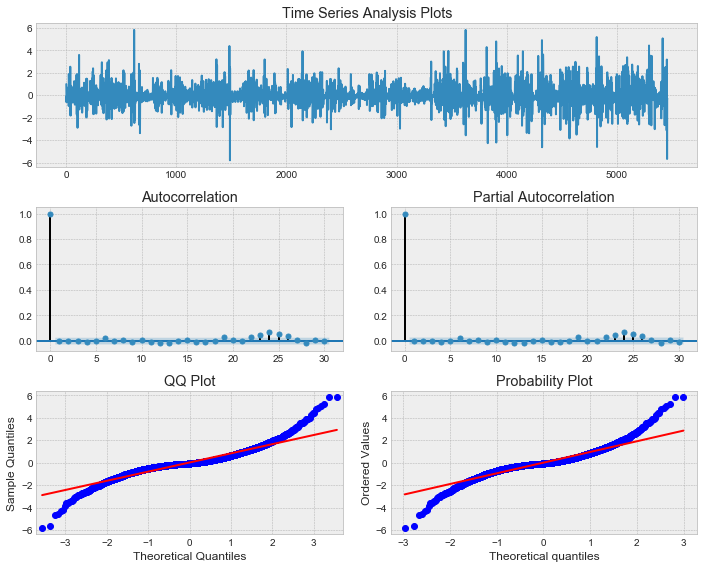

In [13]:
tsplot(arima.resid, lags=30)

### GARCH Model

Here, we generate the GARCH Model. The Orders used for the Model are the Same of the AR and MA part of the ARIMA obtained before.

In [14]:
#aic,order,garch = get_best_GARCH(arima.resid)
garch = arch_model(arima.resid, p=order[0], q=order[2],dist='StudentsT',mean='Zero').fit(disp='off')

In [15]:
print(garch.summary())

Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -5058.35
Distribution:      Standardized Student's t   AIC:                           10130.7
Method:                  Maximum Likelihood   BIC:                           10176.9
                                              No. Observations:                 5458
Date:                      Thu, Jul 02 2020   Df Residuals:                     5451
Time:                              21:39:15   Df Model:                            7
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0268  3.72

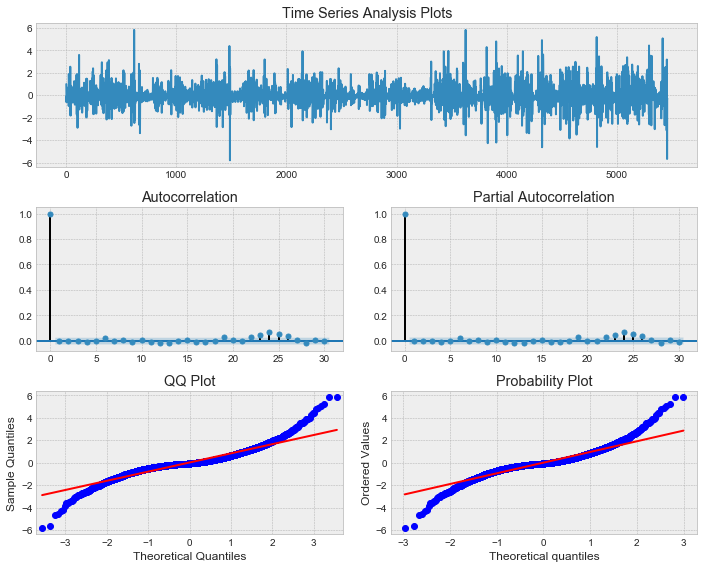

In [16]:
tsplot(garch.resid, lags=30)

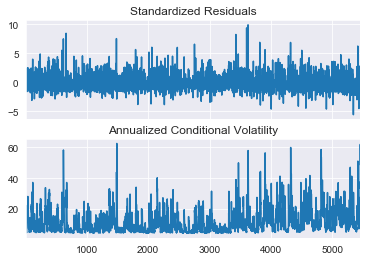

In [17]:
fig = garch.plot(annualize='D')

### Forecast Generation

Finally, here we generate the Forecast, starting with the GARCH Forecasts.

In [18]:
garch_forecasts = garch.forecast(horizon=780)

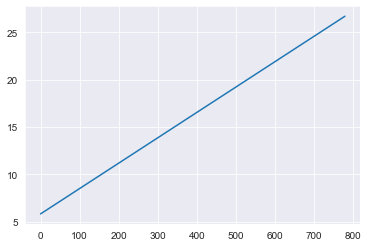

In [19]:
garch_forecasts = pd.DataFrame(garch_forecasts.variance.iloc[-1])
garch_forecasts = garch_forecasts.reset_index().drop('index',axis=1)
garch_forecasts = garch_forecasts.rename({5458:'Forecasts'},axis=1)
plt.plot(garch_forecasts['Forecasts'])

In [20]:
noise = pd.DataFrame(np.random.normal(0,1,780),columns=['Noise'])

In [21]:
garch_forecasts['Forecasts'] = np.sqrt(garch_forecasts['Forecasts']) * noise['Noise']
garch_forecasts.index = y_hold.index

In [22]:
train_set = pd.DataFrame(data=arima.resid,columns=['Train'])
garch_forecasts = pd.DataFrame()
pred_size = 780
for i in range(pred_size):
    garch = arch_model(train_set.values, p=order[0], q=order[2],dist='StudentsT',mean='Zero').fit(disp='off')
    pred = np.sqrt(garch.forecast().variance.iloc[-1].reset_index().drop('index',axis=1)) * np.random.normal(0,1)
    pred.columns = ['Train']
    train_set = train_set.append(pred).reset_index().drop('index',axis=1)
    pred.columns = ['Forecasts']
    garch_forecasts = garch_forecasts.append(pred).reset_index().drop('index',axis=1)

In [23]:
garch_forecasts.index = y_hold.index

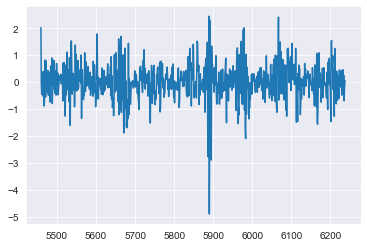

In [24]:
plt.plot(garch_forecasts)

Here, the ARIMA forecasts are Generated and Added with the Conditional Variance obtained above to generate Final Forecasts.

In [25]:
fc, se, conf = arima.forecast(780, alpha=0.05)  # 95% conf

In [26]:
fc_series = pd.Series(fc, index=y_hold.index)
lower_series = pd.Series(conf[:, 0], index=y_hold.index)
upper_series = pd.Series(conf[:, 1], index=y_hold.index)

Finally, Forecasts are plotted.

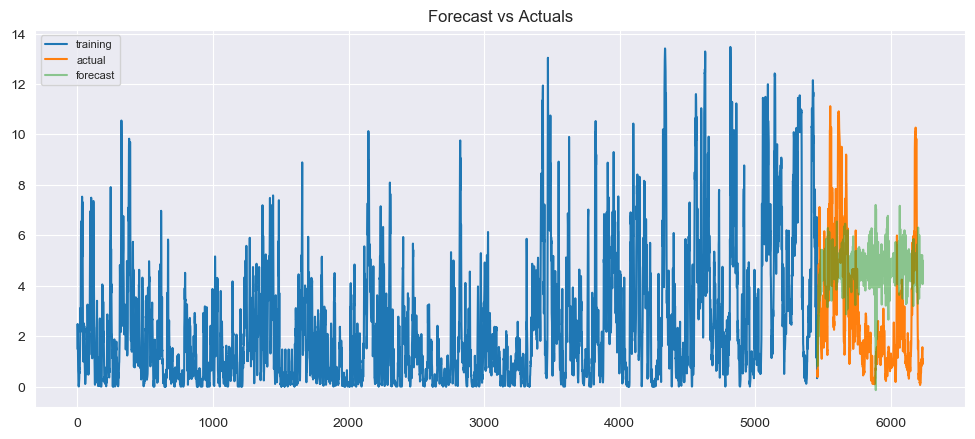

In [27]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train['y'], label='training')
plt.plot(y_hold['y'], label='actual')
plt.plot(garch_forecasts['Forecasts']+ fc_series, label='forecast',alpha=0.5)
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()